# Machine Learning Models Training & Evaluation

## 1. Import Libraries

In [15]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)

import os
import pickle

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import time
from datetime import datetime

print("All libraries imported successfully!\n")

All libraries imported successfully!



## 2. Configuration & Settings

In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

MODEL_PARAMS = {
    'decision_tree': {
        'max_depth': 5,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'random_state': RANDOM_SEED
    },
    'random_forest': {
        'n_estimators': 100,
        'max_depth': 5,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'random_state': RANDOM_SEED,
        'n_jobs': -1
    },
    'xgboost': {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.1,
        'random_state': RANDOM_SEED,
        'eval_metric': 'logloss'
    }
}

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Configuration completed!")

Configuration completed!


## 3. Loading Data

In [ ]:
file_path = r"../data/processed/cleaned_diabetes_data.csv"
df = pd.read_csv(file_path)
df.head()

,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryDiabetes,GestationalDiabetes,PolycysticOvarySyndrome,PreviousPreDiabetes,Hypertension,SystolicBP,DiastolicBP,FastingBloodSugar,HbA1c,SerumCreatinine,BUNLevels,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,AntihypertensiveMedications,Statins,AntidiabeticMedications,FrequentUrination,ExcessiveThirst,UnexplainedWeightLoss,FatigueLevels,BlurredVision,SlowHealingSores,TinglingHandsFeet,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge,Total_Symptoms,Polyuria_Polydipsia,Skin_Issues,Neuro_Symptoms,High_Risk_Combo,BMI_Category
0,6000,44,0,1,2,1,32.985284,1,4.499365,2.443385,4.898831,4.049885,1,1,0,0,0,93,73,163.687162,9.283631,2.665607,28.190147,254.270670,86.993627,70.801469,190.335834,0,0,1,0,0,0,9.534169,0,0,1,73.765109,0,0,0,1.782724,4.486980,7.211349,1,0,1,0,0,0,0,3
1,6001,51,1,0,1,2,39.916764,0,1.578919,8.301264,8.941093,7.508150,0,0,0,0,0,165,99,188.347070,7.326870,4.172177,32.149491,155.358831,110.056105,39.900112,81.172469,0,0,0,0,0,0,0.123214,0,0,0,91.445753,0,0,1,3.381070,5.961705,5.024612,1,0,0,0,0,0,0,3
2,6002,89,1,0,1,3,19.782251,0,1.177301,6.103395,7.722543,7.708387,1,0,0,0,0,119,91,127.703653,4.083426,1.973168,10.018375,231.608922,62.035793,62.480666,279.809069,1,1,0,0,0,0,9.643320,0,0,0,54.485744,0,0,0,2.701019,8.950821,7.034944,0,0,0,0,0,0,0,1
3,6003,21,1,1,1,2,32.376881,1,1.714621,8.645465,4.804044,6.286548,1,1,0,1,0,169,87,82.688415,6.516645,3.057797,44.123281,176.592374,68.238410,46.977819,112.751396,0,0,1,0,0,0,3.403557,0,0,0,77.866758,0,0,1,1.409056,3.124769,4.717774,0,0,0,0,0,0,0,3
4,6004,27,1,0,1,3,16.808600,0,15.462549,4.629383,2.532756,9.771125,0,0,0,0,0,165,69,90.743395,5.607222,4.150353,7.757117,157.344121,66.476215,40.059755,381.528785,1,1,0,0,0,0,2.924687,0,0,0,37.731808,0,0,0,1.218452,6.977741,7.887940,0,0,0,0,0,0,0,0


## 4. Data Splitting

In [19]:
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y, shuffle=True)

## 5. Helper Functions

In [58]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
  print(f"EVALUATING {model_name.upper()}:\n ")

  # Predictions
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # Probability predictions (for ROC curve)
  if hasattr(model, 'predict_proba'):
      y_test_proba = model.predict_proba(X_test)[:, 1]
  else:
      y_test_proba = y_test_pred

  # Calculate metrics
  metrics = {
      'train_accuracy': accuracy_score(y_train, y_train_pred),
      'test_accuracy': accuracy_score(y_test, y_test_pred),
      'precision': precision_score(y_test, y_test_pred),
      'recall': recall_score(y_test, y_test_pred),
      'f1_score': f1_score(y_test, y_test_pred),
      'roc_auc': roc_auc_score(y_test, y_test_proba) if len(np.unique(y_test)) > 1 else 0
  }

  # Display metrics
  print("Performance Metrics:")
  print(f"   Training Accuracy:   {metrics['train_accuracy']:.4f} ({metrics['train_accuracy']*100:.2f}%)")
  print(f"   Testing Accuracy:    {metrics['test_accuracy']:.4f} ({metrics['test_accuracy']*100:.2f}%)")
  print(f"   Precision:           {metrics['precision']:.4f}")
  print(f"   Recall:              {metrics['recall']:.4f}")
  print(f"   F1-Score:            {metrics['f1_score']:.4f}")
  print(f"   ROC-AUC Score:       {metrics['roc_auc']:.4f}")

  # Overfitting check
  overfit_diff = metrics['train_accuracy'] - metrics['test_accuracy']
  print(f"\n   Overfitting Check:   {overfit_diff:.4f}", end="")
  if overfit_diff > 0.1:
      print(" High overfitting detected!")
  elif overfit_diff > 0.05:
      print(" Moderate overfitting")
  else:
      print(" Good generalization")

  # Classification Report
  print(f"\nClassification Report:")
  print(classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes']))

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_test_pred)

  # Visualizations
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  # Confusion Matrix Heatmap
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
              xticklabels=['No Diabetes', 'Diabetes'],
              yticklabels=['No Diabetes', 'Diabetes'])
  axes[0].set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
  axes[0].set_ylabel('True Label', fontsize=12)
  axes[0].set_xlabel('Predicted Label', fontsize=12)

  # ROC Curve
  if len(np.unique(y_test)) > 1:
      fpr, tpr, _ = roc_curve(y_test, y_test_proba)
      axes[1].plot(fpr, tpr, color='darkorange', lw=2,
                  label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
      axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
      axes[1].set_xlim([0.0, 1.0])
      axes[1].set_ylim([0.0, 1.05])
      axes[1].set_xlabel('False Positive Rate', fontsize=12)
      axes[1].set_ylabel('True Positive Rate', fontsize=12)
      axes[1].set_title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
      axes[1].legend(loc="lower right")
      axes[1].grid(alpha=0.3)

  plt.tight_layout()
  plt.show()

  return metrics

In [22]:
def cross_validate_model(model, X, y, model_name, cv=5):

  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
  cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

  print(f"   Fold Scores: {[f'{score:.4f}' for score in cv_scores]}")
  print(f"   Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

  return {
      'cv_scores': cv_scores,
      'cv_mean': cv_scores.mean(),
      'cv_std': cv_scores.std()
  }

## 6. MODEL TRAINING & EVALUATION

In [23]:
all_results = {}

### 6.1 Decision Tree Classifier

#### 6.1.1 Model Training - Prediction

In [24]:
dt_model = DecisionTreeClassifier(**MODEL_PARAMS['decision_tree'])

start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Decision Tree Training completed in {training_time:.2f} seconds")

Decision Tree Training completed in 0.04 seconds


#### 6.1.2 Model Evaluation

In [25]:
dt_cv_results = cross_validate_model(dt_model, X_train, y_train, "Decision Tree")

   Fold Scores: ['0.9103', '0.8937', '0.9336', '0.9167', '0.9200']
   Mean CV Accuracy: 0.9148 (+/- 0.0260)


EVALUATING DECISION TREE:
 
Performance Metrics:
   Training Accuracy:   0.9481 (94.81%)
   Testing Accuracy:    0.9229 (92.29%)
   Precision:           0.9353
   Recall:              0.8667
   F1-Score:            0.8997
   ROC-AUC Score:       0.9433

   Overfitting Check:   0.0252 Good generalization

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.92      0.96      0.94       226
    Diabetes       0.94      0.87      0.90       150

    accuracy                           0.92       376
   macro avg       0.93      0.91      0.92       376
weighted avg       0.92      0.92      0.92       376



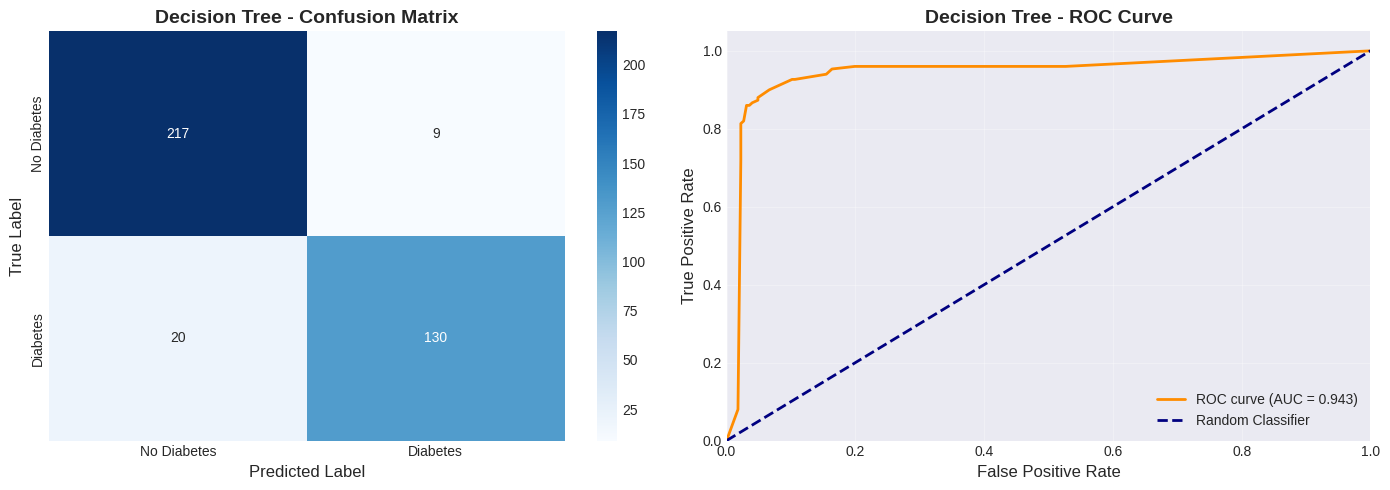

In [59]:
dt_metrics = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")

Top 10 Important Features (Decision Tree):
              Feature  Importance
20              HbA1c    0.455875
19  FastingBloodSugar    0.316268
0           PatientID    0.058315
16       Hypertension    0.051911
30  FrequentUrination    0.036163
31    ExcessiveThirst    0.022298
5      EducationLevel    0.021503
9    PhysicalActivity    0.011061
24     CholesterolLDL    0.007892
10        DietQuality    0.004354


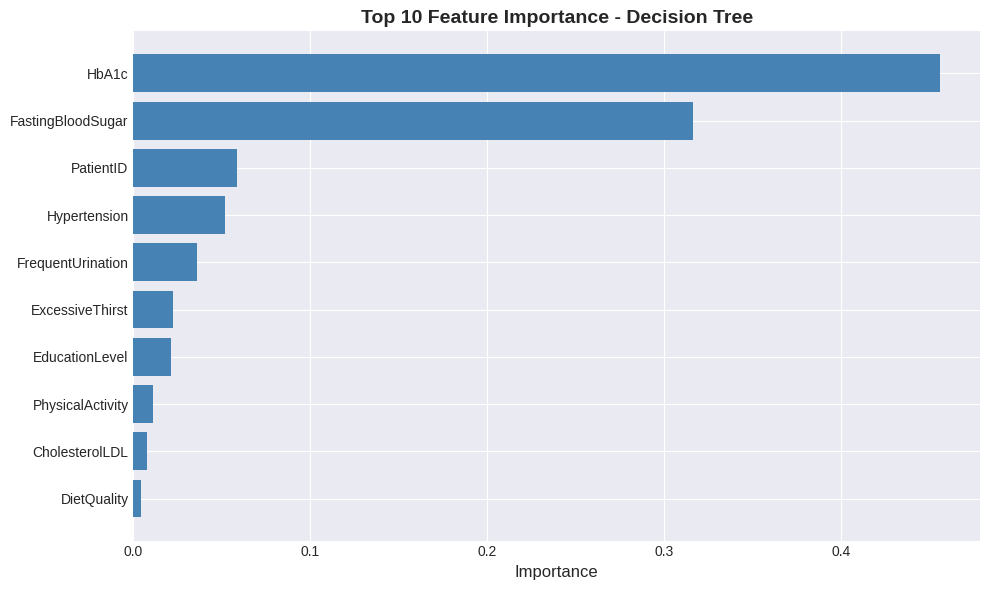

In [31]:
feature_importance_dt = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Important Features (Decision Tree):")
print(feature_importance_dt.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance_dt.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [32]:
all_results['Decision Tree'] = {**dt_metrics, **dt_cv_results, 'training_time': training_time}

### 6.2 Random Forest Classifier

#### 6.2.1 Model Training - Prediction

In [33]:
rf_model = RandomForestClassifier(**MODEL_PARAMS['random_forest'])

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Random Forest Training completed in {training_time:.2f} seconds")

Random Forest Training completed in 1.17 seconds


#### 6.2.2 Model Evaluation

In [34]:
rf_cv_results = cross_validate_model(rf_model, X_train, y_train, "Random Forest")

   Fold Scores: ['0.9302', '0.8870', '0.9236', '0.8800', '0.8967']
   Mean CV Accuracy: 0.9035 (+/- 0.0399)


EVALUATING RANDOM FOREST:
 
Performance Metrics:
   Training Accuracy:   0.9242 (92.42%)
   Testing Accuracy:    0.9069 (90.69%)
   Precision:           0.9457
   Recall:              0.8133
   F1-Score:            0.8746
   ROC-AUC Score:       0.9703

   Overfitting Check:   0.0172 Good generalization

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.89      0.97      0.93       226
    Diabetes       0.95      0.81      0.87       150

    accuracy                           0.91       376
   macro avg       0.92      0.89      0.90       376
weighted avg       0.91      0.91      0.91       376



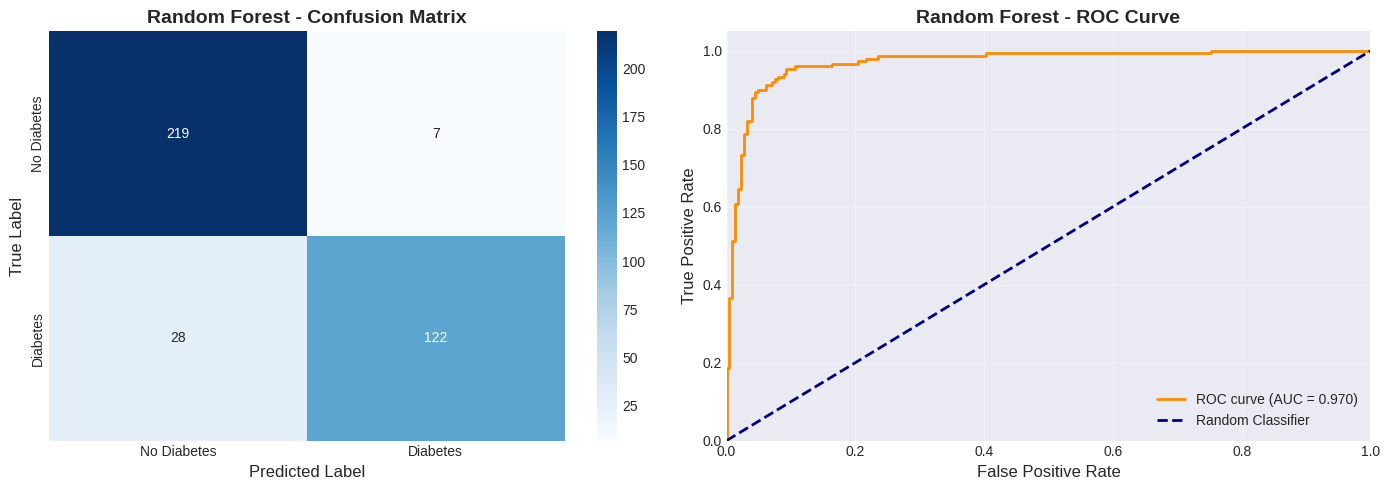

In [60]:
rf_metrics = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

Top 10 Important Features (Random Forest):
              Feature  Importance
19  FastingBloodSugar    0.358399
20              HbA1c    0.297363
30  FrequentUrination    0.035742
16       Hypertension    0.027515
0           PatientID    0.025496
17         SystolicBP    0.020719
43     HealthLiteracy    0.014723
10        DietQuality    0.014444
6                 BMI    0.013473
23   CholesterolTotal    0.013353


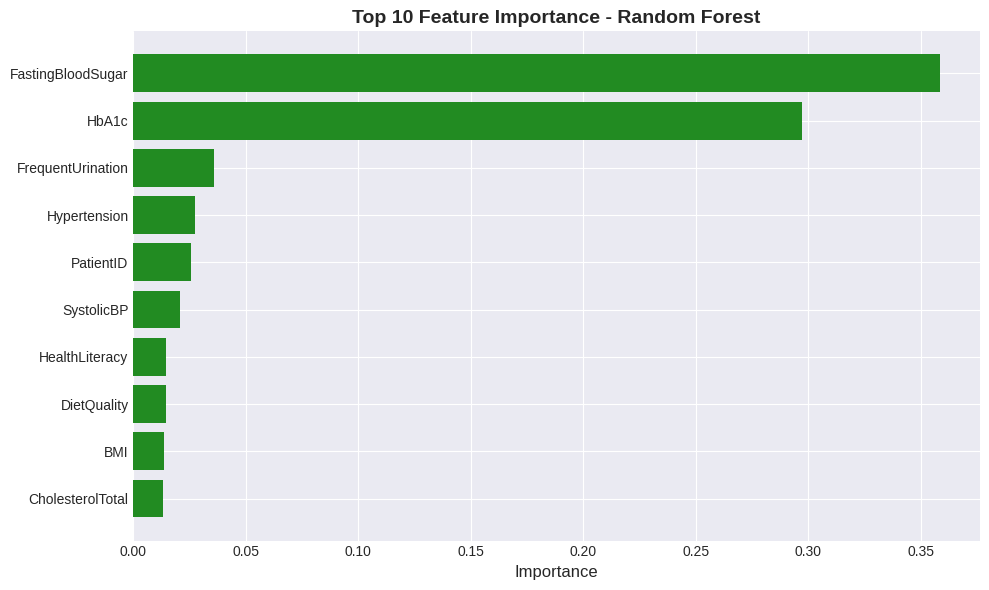

In [36]:
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Important Features (Random Forest):")
print(feature_importance_rf.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance_rf.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [37]:
all_results['Random Forest'] = {**rf_metrics, **rf_cv_results, 'training_time': training_time}

### 6.3 XGBOOST Classifier

#### 6.3.1 Model Training - Prediction

In [38]:
xgb_model = xgb.XGBClassifier(**MODEL_PARAMS['xgboost'])

start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"XGBoost Training completed in {training_time:.2f} seconds")

XGBoost Training completed in 0.27 seconds


#### 6.3.2 Model Evaluation

In [39]:
xgb_cv_results = cross_validate_model(xgb_model, X_train, y_train, "XGBoost")

   Fold Scores: ['0.9269', '0.9269', '0.9502', '0.9167', '0.9300']
   Mean CV Accuracy: 0.9301 (+/- 0.0220)


EVALUATING XGBOOST:
 
Performance Metrics:
   Training Accuracy:   1.0000 (100.00%)
   Testing Accuracy:    0.9388 (93.88%)
   Precision:           0.9262
   Recall:              0.9200
   F1-Score:            0.9231
   ROC-AUC Score:       0.9897

   Overfitting Check:   0.0612 Moderate overfitting

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.95      0.95      0.95       226
    Diabetes       0.93      0.92      0.92       150

    accuracy                           0.94       376
   macro avg       0.94      0.94      0.94       376
weighted avg       0.94      0.94      0.94       376



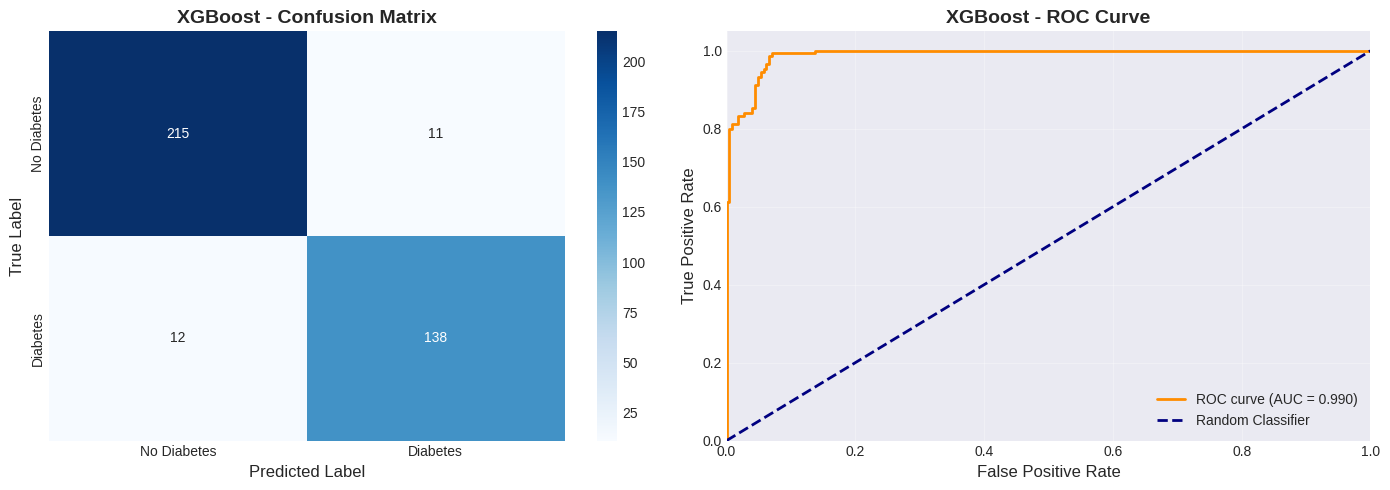

In [61]:
xgb_metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

Top 10 Important Features (XGBoost):
                  Feature  Importance
20                  HbA1c    0.196987
19      FastingBloodSugar    0.176320
30      FrequentUrination    0.063392
16           Hypertension    0.059970
0               PatientID    0.047887
31        ExcessiveThirst    0.041007
32  UnexplainedWeightLoss    0.036101
5          EducationLevel    0.027634
28                Statins    0.022893
9        PhysicalActivity    0.022308


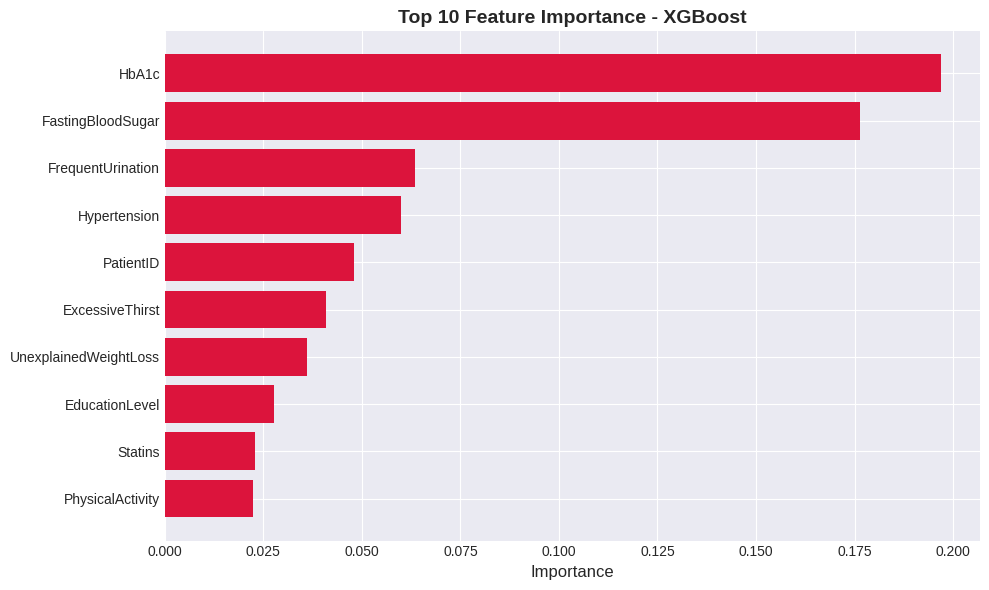

In [41]:
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Important Features (XGBoost):")
print(feature_importance_xgb.head(10))

plt.figure(figsize=(10, 6))
top_features = feature_importance_xgb.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='crimson')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [42]:
all_results['XGBoost'] = {**xgb_metrics, **xgb_cv_results, 'training_time': training_time}

## 7. Comprehensive Model Comparison

#### 7.1 Create comparison DataFrame

In [43]:
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Train Accuracy': [all_results[model]['train_accuracy'] for model in all_results],
    'Test Accuracy': [all_results[model]['test_accuracy'] for model in all_results],
    'Precision': [all_results[model]['precision'] for model in all_results],
    'Recall': [all_results[model]['recall'] for model in all_results],
    'F1-Score': [all_results[model]['f1_score'] for model in all_results],
    'ROC-AUC': [all_results[model]['roc_auc'] for model in all_results],
    'CV Mean': [all_results[model]['cv_mean'] for model in all_results],
    'CV Std': [all_results[model]['cv_std'] for model in all_results],
    'Training Time (s)': [all_results[model]['training_time'] for model in all_results]
})

print("Model Performance Summary:")
print(comparison_df.to_string(index=False))

Model Performance Summary:
        Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV Mean   CV Std  Training Time (s)
Decision Tree        0.948104       0.922872   0.935252 0.866667  0.899654 0.943304 0.914842 0.013025           0.035980
Random Forest        0.924152       0.906915   0.945736 0.813333  0.874552 0.970265 0.903506 0.019940           1.171816
      XGBoost        1.000000       0.938830   0.926174 0.920000  0.923077 0.989735 0.930131 0.010986           0.274267


#### 7.2 Best Accuracy Model

In [44]:
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"Best Model: {best_model_name} with Test Accuracy: {comparison_df.loc[best_model_idx, 'Test Accuracy']:.4f}")

Best Model: XGBoost with Test Accuracy: 0.9388


#### 7.3 Visualization: Multiple metrics comparison

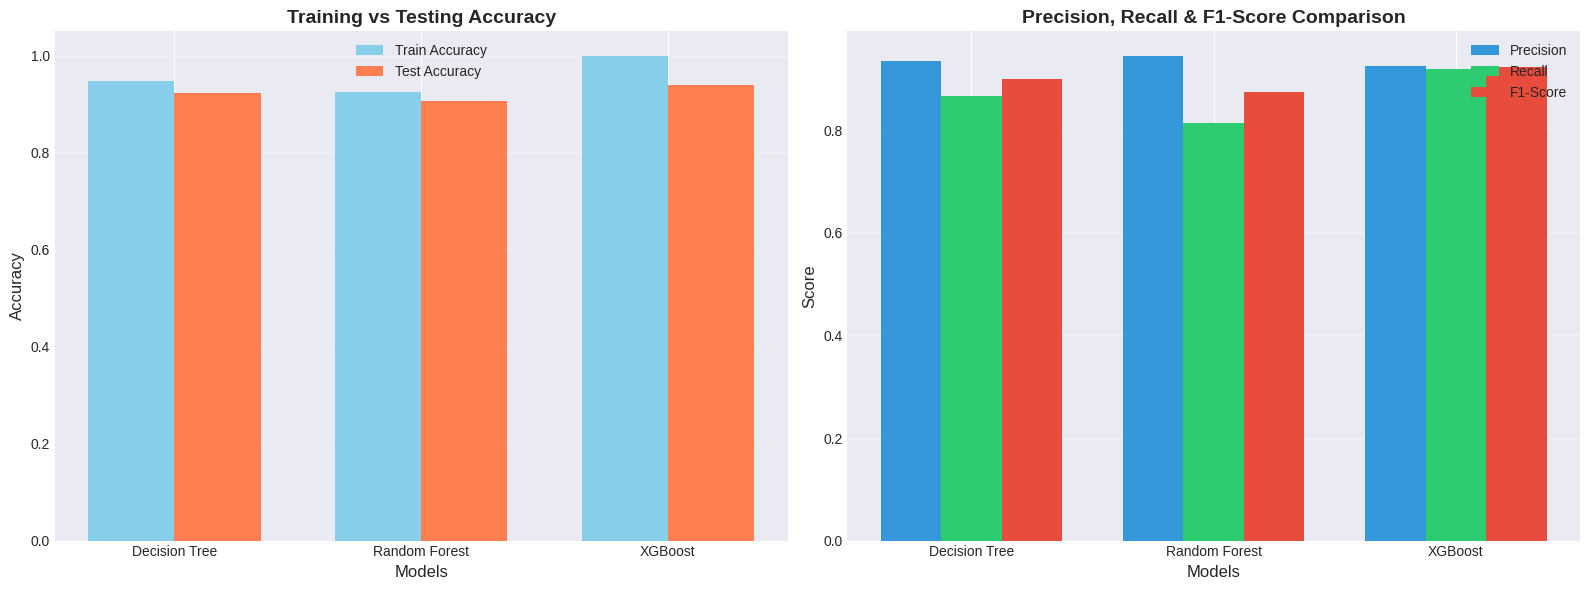

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy Comparison
ax1 = axes[0]
x_pos = np.arange(len(comparison_df))
width = 0.35
ax1.bar(x_pos - width/2, comparison_df['Train Accuracy'], width, label='Train Accuracy', color='skyblue')
ax1.bar(x_pos + width/2, comparison_df['Test Accuracy'], width, label='Test Accuracy', color='coral')
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training vs Testing Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Precision, Recall, F1-Score
ax2 = axes[1]
metrics_to_plot = comparison_df[['Precision', 'Recall', 'F1-Score']].values
x_pos = np.arange(len(comparison_df))
width = 0.25
ax2.bar(x_pos - width, metrics_to_plot[:, 0], width, label='Precision', color='#3498db')
ax2.bar(x_pos, metrics_to_plot[:, 1], width, label='Recall', color='#2ecc71')
ax2.bar(x_pos + width, metrics_to_plot[:, 2], width, label='F1-Score', color='#e74c3c')
ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Precision, Recall & F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

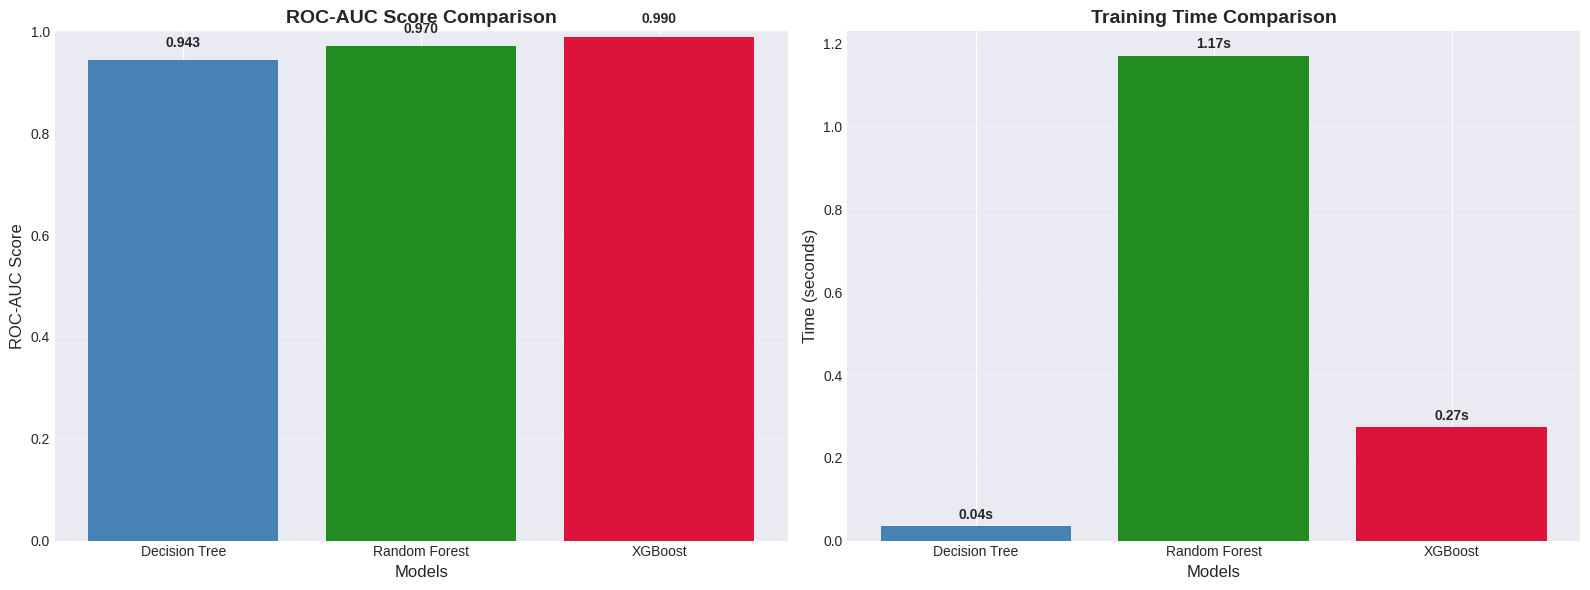

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 3. ROC-AUC Score
ax3 = axes[0]
ax3.bar(comparison_df['Model'], comparison_df['ROC-AUC'], color=['steelblue', 'forestgreen', 'crimson'])
ax3.set_xlabel('Models', fontsize=12)
ax3.set_ylabel('ROC-AUC Score', fontsize=12)
ax3.set_title('ROC-AUC Score Comparison', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['ROC-AUC']):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Training Time
ax4 = axes[1]
ax4.bar(comparison_df['Model'], comparison_df['Training Time (s)'], color=['steelblue', 'forestgreen', 'crimson'])
ax4.set_xlabel('Models', fontsize=12)
ax4.set_ylabel('Time (seconds)', fontsize=12)
ax4.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Training Time (s)']):
    ax4.text(i, v + 0.01, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 7.4 Cross-validation comparison

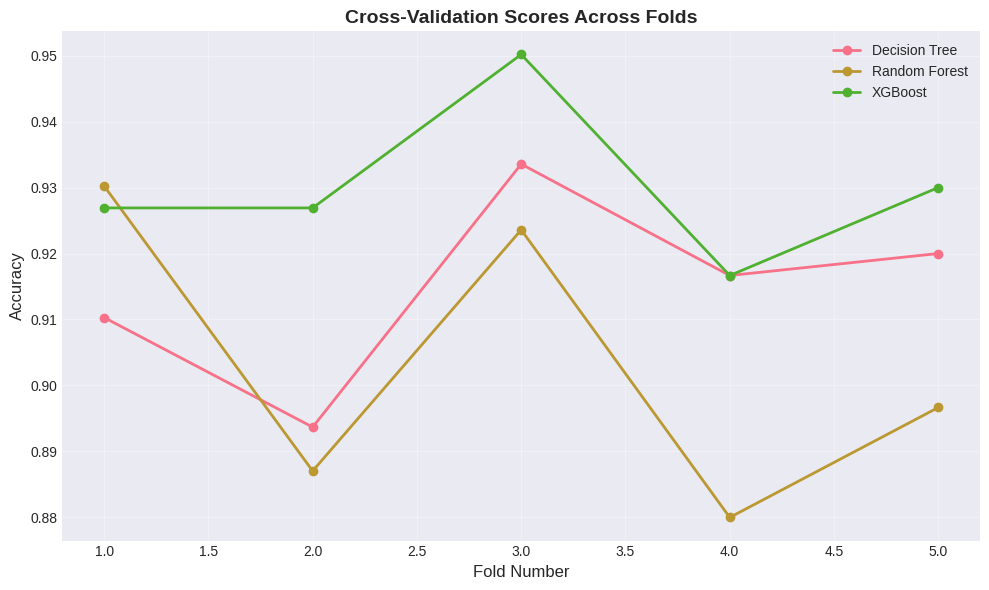

In [ ]:
plt.figure(figsize=(10, 6))
for model in all_results.keys():
    cv_scores = all_results[model]['cv_scores']
    plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', label=model, linewidth=2)

plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Scores Across Folds', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 8. Save The Results

In [ ]:
os.makedirs('../results/saved_models', exist_ok=True)

with open('../results/saved_models/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("Decision Tree saved!")

with open('../results/saved_models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("Random Forest saved!")

with open('../results/saved_models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("XGBoost saved!")

print("All models saved successfully in 'results/saved_models/' folder\n")